# Predict Human Responses: Curse of Knowledge Analysis

This notebook analyzes whether language models can predict human the "curse of knowledge" bias in false-belief reasoning, comparing curse-of-knowledge bias when asked to simulate human responses, comparing from Birch & Bloom (2007).

## Background

**The Curse of Knowledge**: A cognitive bias where one's own knowledge of an outcome compromises the ability to reason about another person's beliefs about that outcome.

**Experimental Design**:
- 3 conditions: Ignorance, Knowledge-Plausible, Knowledge-Implausible
- 5 models: GPT-4o-mini, GPT-4o, GPT-5-low, GPT-5-medium, GPT-5-high
- Comparison with human baseline (Birch & Bloom 2007)

In [1]:
import pandas as pd
import numpy as np
import json
import re
from scipy import stats
from plotnine import *
import warnings
warnings.filterwarnings('ignore')

print("Libraries loaded successfully")

Libraries loaded successfully


## Step 1: Load and Parse Data

In [2]:
# Load data
df = pd.read_csv("model_responses_predict_human.csv")
print(f"Loaded {len(df)} rows")
print(f"Columns: {df.columns.tolist()}")
df.head()

Loaded 1350 rows
Columns: ['names', 'colors', 'condition', 'model', 'trial', 'stimulus', 'result', 'reasoning']


,names,colors,condition,model,trial,stimulus,result,reasoning
0,"('Alice', 'Beth')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,0,Consider the following scenario: \n In a ro...,"<answer>\n{\n ""blue"": 80,\n ""purple"": 4,...",**Analyzing false-belief task**\n\nI need to i...
1,"('Alice', 'Beth')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,1,Consider the following scenario: \n In a ro...,"<answer>\n{\n ""blue"": 85,\n ""purple"": 5,...",**Analyzing false-belief prediction**\n\nI nee...
2,"('Alice', 'Beth')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,2,Consider the following scenario: \n In a ro...,"<answer>\n{\n ""blue"": 82,\n ""purple"": 4,...",NaN
3,"('Alice', 'Beth')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,3,Consider the following scenario: \n In a ro...,"<answer>\n{\n ""blue"": 90,\n ""purple"": 3,...",**Modeling False Belief**\n\nI'm trying to mod...
4,"('Alice', 'Beth')","('blue', 'purple', 'red', 'green')",Ignorance,gpt-5-low,4,Consider the following scenario: \n In a ro...,"<answer>\n{\n ""blue"": 80,\n ""purple"": 4,...",**Analyzing color positions**\n\nI'm figuring ...


In [3]:
# Parse JSON from result column
def extract_percentages(result_str):
    """Extract percentage values from <answer> JSON tags"""
    try:
        match = re.search(r'<answer>\s*(\{.*?\})\s*</answer>', result_str, re.DOTALL)
        if match:
            json_str = match.group(1)
            data = json.loads(json_str)
            return data
        else:
            return None
    except:
        return None

df['percentages'] = df['result'].apply(extract_percentages)

# Expand percentages into separate columns
df['blue_pct'] = df['percentages'].apply(lambda x: x.get('blue', np.nan) if x else np.nan)
df['purple_pct'] = df['percentages'].apply(lambda x: x.get('purple', np.nan) if x else np.nan)
df['red_pct'] = df['percentages'].apply(lambda x: x.get('red', np.nan) if x else np.nan)
df['green_pct'] = df['percentages'].apply(lambda x: x.get('green', np.nan) if x else np.nan)

print(f"Successfully parsed: {df['percentages'].notna().sum()} / {len(df)} responses")

# Verify all sum to 100
df['total_pct'] = df['blue_pct'] + df['purple_pct'] + df['red_pct'] + df['green_pct']
print(f"Responses summing to 100%: {(df['total_pct'].round(0) == 100).sum()} / {len(df)}")

Successfully parsed: 1350 / 1350 responses
Responses summing to 100%: 1350 / 1350


## Step 2: Apply Color Mapping

Two color sets exist in the data. We map the second set to match the first for consistency:
- Color set 1: `('blue', 'purple', 'red', 'green')` - keep as is
- Color set 2: `('green', 'red', 'purple', 'blue')` - map: green→blue, red→purple, purple→red, blue→green

In [4]:
# Check color sets
color_set_1 = "('blue', 'purple', 'red', 'green')"
color_set_2 = "('green', 'red', 'purple', 'blue')"

print(f"Color set 1: {color_set_1}")
print(f"  Count: {(df['colors'] == color_set_1).sum()} rows")
print(f"\nColor set 2: {color_set_2}")
print(f"  Count: {(df['colors'] == color_set_2).sum()} rows")

# Apply color mapping for set 2
mask_set2 = df['colors'] == color_set_2

# Create mapped columns
df['blue_mapped'] = df['blue_pct'].copy()
df['purple_mapped'] = df['purple_pct'].copy()
df['red_mapped'] = df['red_pct'].copy()
df['green_mapped'] = df['green_pct'].copy()

# Apply swapping for set 2: green→blue, red→purple, purple→red, blue→green
df.loc[mask_set2, 'blue_mapped'] = df.loc[mask_set2, 'green_pct']
df.loc[mask_set2, 'purple_mapped'] = df.loc[mask_set2, 'red_pct']
df.loc[mask_set2, 'red_mapped'] = df.loc[mask_set2, 'purple_pct']
df.loc[mask_set2, 'green_mapped'] = df.loc[mask_set2, 'blue_pct']

print("\n✓ Color mapping applied successfully")

Color set 1: ('blue', 'purple', 'red', 'green')
  Count: 675 rows

Color set 2: ('green', 'red', 'purple', 'blue')
  Count: 675 rows

✓ Color mapping applied successfully


## Step 3: Sensitivity Analysis

Verify that there are no significant differences across sensitivity factors (name pairs, instruments, trials, color sets).

In [5]:
# Extract instrument from stimulus
def extract_instrument(stimulus):
    if 'violin' in stimulus.lower():
        return 'violin'
    elif 'flute' in stimulus.lower():
        return 'flute'
    elif 'ball' in stimulus.lower():
        return 'ball'
    else:
        return 'unknown'

df['instrument'] = df['stimulus'].apply(extract_instrument)

# Run ANOVA for sensitivity factors
sensitivity_factors = ['names', 'instrument', 'trial', 'colors']
containers = ['blue_mapped', 'red_mapped']  # Focus on key containers

results = []
for factor in sensitivity_factors:
    row = {'Factor': factor}
    for container in containers:
        groups = [group[container].dropna() for name, group in df.groupby(factor)]
        if len(groups) > 1 and all(len(g) > 0 for g in groups):
            f_stat, p_val = stats.f_oneway(*groups)
            row[container.replace('_mapped', '')] = f"{p_val:.4f}"
        else:
            row[container.replace('_mapped', '')] = "N/A"
    results.append(row)

sensitivity_df = pd.DataFrame(results)
print("\nSensitivity Analysis (ANOVA p-values):")
print("Note: p > 0.05 indicates no significant difference (safe to aggregate)\n")
display(sensitivity_df)


Sensitivity Analysis (ANOVA p-values):
Note: p > 0.05 indicates no significant difference (safe to aggregate)



,Factor,blue,red
0,names,0.8857,0.2648
1,instrument,0.8891,0.8005
2,trial,0.9949,0.8771
3,colors,0.9143,0.0466


## Step 4: Aggregate Data

Aggregate by model, condition, and container to compute mean percentages and standard deviations.

In [6]:
# Reshape to long format
df_long = pd.melt(
    df,
    id_vars=['model', 'condition', 'names', 'instrument', 'trial'],
    value_vars=['blue_mapped', 'purple_mapped', 'red_mapped', 'green_mapped'],
    var_name='container',
    value_name='percentage'
)

# Clean container names
df_long['container'] = df_long['container'].str.replace('_mapped', '')

# Aggregate
agg_data = df_long.groupby(['model', 'condition', 'container'])['percentage'].agg(
    ['mean', 'std', 'count']
).reset_index()

print(f"Aggregated to {len(agg_data)} rows")
print(f"\nModels: {sorted(agg_data['model'].unique())}")
print(f"Conditions: {sorted(agg_data['condition'].unique())}")
print(f"Containers: {sorted(agg_data['container'].unique())}")

Aggregated to 60 rows

Models: ['gpt-4o', 'gpt-4o-mini', 'gpt-5-high', 'gpt-5-low', 'gpt-5-medium']
Conditions: ['Ignorance', 'Knowledge-implausible', 'Knowledge-plausible']
Containers: ['blue', 'green', 'purple', 'red']


## Step 5: Add Human Benchmark Data

Include human performance data from Birch & Bloom (2007) for comparison.

In [7]:
# Human data from Birch & Bloom 2007
human_data = pd.DataFrame([
    # Ignorance condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'blue', 'mean': 71, 'std': 26, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'red', 'mean': 23, 'std': 22, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'purple', 'mean': 2, 'std': 5, 'count': 56},
    {'model': 'Humans (B&B 2007)', 'condition': 'Ignorance', 'container': 'green', 'mean': 3, 'std': 7, 'count': 56},
    
    # Knowledge-Plausible condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'blue', 'mean': 59, 'std': 27, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'red', 'mean': 34, 'std': 25, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'purple', 'mean': 3, 'std': 5, 'count': 51},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-plausible', 'container': 'green', 'mean': 4, 'std': 7, 'count': 51},
    
    # Knowledge-Implausible condition
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'blue', 'mean': 71, 'std': 29, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'red', 'mean': 19, 'std': 21, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'purple', 'mean': 6, 'std': 16, 'count': 43},
    {'model': 'Humans (B&B 2007)', 'condition': 'Knowledge-implausible', 'container': 'green', 'mean': 3, 'std': 5, 'count': 43},
])

# Combine model and human data
combined_data = pd.concat([agg_data, human_data], ignore_index=True)

print(f"Total rows with humans: {len(combined_data)}")
print("\n✓ Human benchmark data added")

Total rows with humans: 72

✓ Human benchmark data added


## Step 6: Summary Statistics Table

In [8]:
# Create summary table
model_order = ['gpt-4o-mini', 'gpt-4o', 'gpt-5-low', 'gpt-5-medium', 'gpt-5-high', 'Humans (B&B 2007)']
model_display_names = {
    'gpt-4o-mini': 'GPT-4o-mini',
    'gpt-4o': 'GPT-4o',
    'gpt-5-low': 'GPT-5-low',
    'gpt-5-medium': 'GPT-5-medium',
    'gpt-5-high': 'GPT-5-high',
    'Humans (B&B 2007)': 'Humans (B&B 2007)'
}
container_order = ['blue', 'purple', 'red', 'green']

summary = combined_data.pivot_table(
    index=['model', 'condition'],
    columns='container',
    values='mean',
    aggfunc='first'
)[container_order]

# Reorder models
summary = summary.reindex(model_order, level=0)

# Rename index for display
summary.index = summary.index.set_levels(
    [model_display_names.get(m, m) for m in summary.index.levels[0]], 
    level=0
)

print("\nSummary Statistics (Mean Percentages):")
print("=" * 80)
display(summary.round(1))


Summary Statistics (Mean Percentages):


container                                blue  purple   red  green
model             condition                                       
GPT-4o-mini       Ignorance              26.4    24.5  24.3   24.7
                  Knowledge-implausible  22.3    54.2  13.4   10.0
                  Knowledge-plausible    23.9    22.3  35.9   17.8
GPT-4o            Ignorance              65.6    13.9  10.4   10.1
                  Knowledge-implausible  65.7    24.1   5.2    5.0
                  Knowledge-plausible    67.1     9.9  14.3    8.7
GPT-5-low         Ignorance              82.8     4.2   9.0    4.0
                  Knowledge-implausible  76.3     9.2  12.1    2.5
                  Knowledge-plausible    80.9     3.4  12.9    2.8
GPT-5-medium      Ignorance              82.2     3.2  11.8    2.8
                  Knowledge-implausible  79.9    10.0   8.2    1.9
                  Knowledge-plausible    81.5     3.0  13.2    2.4
GPT-5-high        Ignorance              84.9     3.4   8.8    2.9
                  Knowledge-implausible  83.0     9.6   5.7    1.7
                  Knowledge-plausible    82.2     3.1  12.5    2.3
Humans (B&B 2007) Ignorance              71.0     2.0  23.0    3.0
                  Knowledge-implausible  71.0     6.0  19.0    3.0
                  Knowledge-plausible    59.0     3.0  34.0    4.0

## Step 7: Key Comparisons (Curse of Knowledge Effects)

In [9]:
print("Key Comparisons (Curse of Knowledge Effects)")
print("=" * 80)

comparison_results = []

for model_name in model_order:
    model_subset = combined_data[combined_data['model'] == model_name]
    
    # Get values
    ig_blue = model_subset[(model_subset['condition'] == 'Ignorance') & 
                           (model_subset['container'] == 'blue')]['mean'].values[0]
    ig_red = model_subset[(model_subset['condition'] == 'Ignorance') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    kp_blue = model_subset[(model_subset['condition'] == 'Knowledge-plausible') & 
                           (model_subset['container'] == 'blue')]['mean'].values[0]
    kp_red = model_subset[(model_subset['condition'] == 'Knowledge-plausible') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    ki_red = model_subset[(model_subset['condition'] == 'Knowledge-implausible') & 
                          (model_subset['container'] == 'red')]['mean'].values[0]
    
    # Calculate differences
    blue_diff = kp_blue - ig_blue
    red_diff = kp_red - ig_red
    plaus_diff = kp_red - ki_red
    
    comparison_results.append({
        'Model': model_display_names.get(model_name, model_name),
        'Blue (Ign)': f"{ig_blue:.1f}%",
        'Blue (K-P)': f"{kp_blue:.1f}%",
        'Blue Δ': f"{blue_diff:+.1f}%",
        'Red (Ign)': f"{ig_red:.1f}%",
        'Red (K-P)': f"{kp_red:.1f}%",
        'Red Δ': f"{red_diff:+.1f}%",
        'Red (K-I)': f"{ki_red:.1f}%",
        'Plausibility Δ': f"{plaus_diff:+.1f}%"
    })

comparison_df = pd.DataFrame(comparison_results)
display(comparison_df)

print("\nNote: Δ = difference between conditions")
print("Negative Blue Δ and positive Red Δ indicate curse-of-knowledge bias")

Key Comparisons (Curse of Knowledge Effects)


,Model,Blue (Ign),Blue (K-P),Blue Δ,Red (Ign),Red (K-P),Red Δ,Red (K-I),Plausibility Δ
0,GPT-4o-mini,26.4%,23.9%,-2.5%,24.3%,35.9%,+11.6%,13.4%,+22.5%
1,GPT-4o,65.6%,67.1%,+1.5%,10.4%,14.3%,+3.9%,5.2%,+9.1%
2,GPT-5-low,82.8%,80.9%,-1.9%,9.0%,12.9%,+4.0%,12.1%,+0.9%
3,GPT-5-medium,82.2%,81.5%,-0.7%,11.8%,13.2%,+1.4%,8.2%,+5.0%
4,GPT-5-high,84.9%,82.2%,-2.7%,8.8%,12.5%,+3.7%,5.7%,+6.8%
5,Humans (B&B 2007),71.0%,59.0%,-12.0%,23.0%,34.0%,+11.0%,19.0%,+15.0%



Note: Δ = difference between conditions
Negative Blue Δ and positive Red Δ indicate curse-of-knowledge bias


## Step 8: Visualization (3 rows × 6 columns)

Each row represents a condition, each column represents a model (5 models + humans).


✓ Saved visualization to 'analysis_plot_predict_human.png'


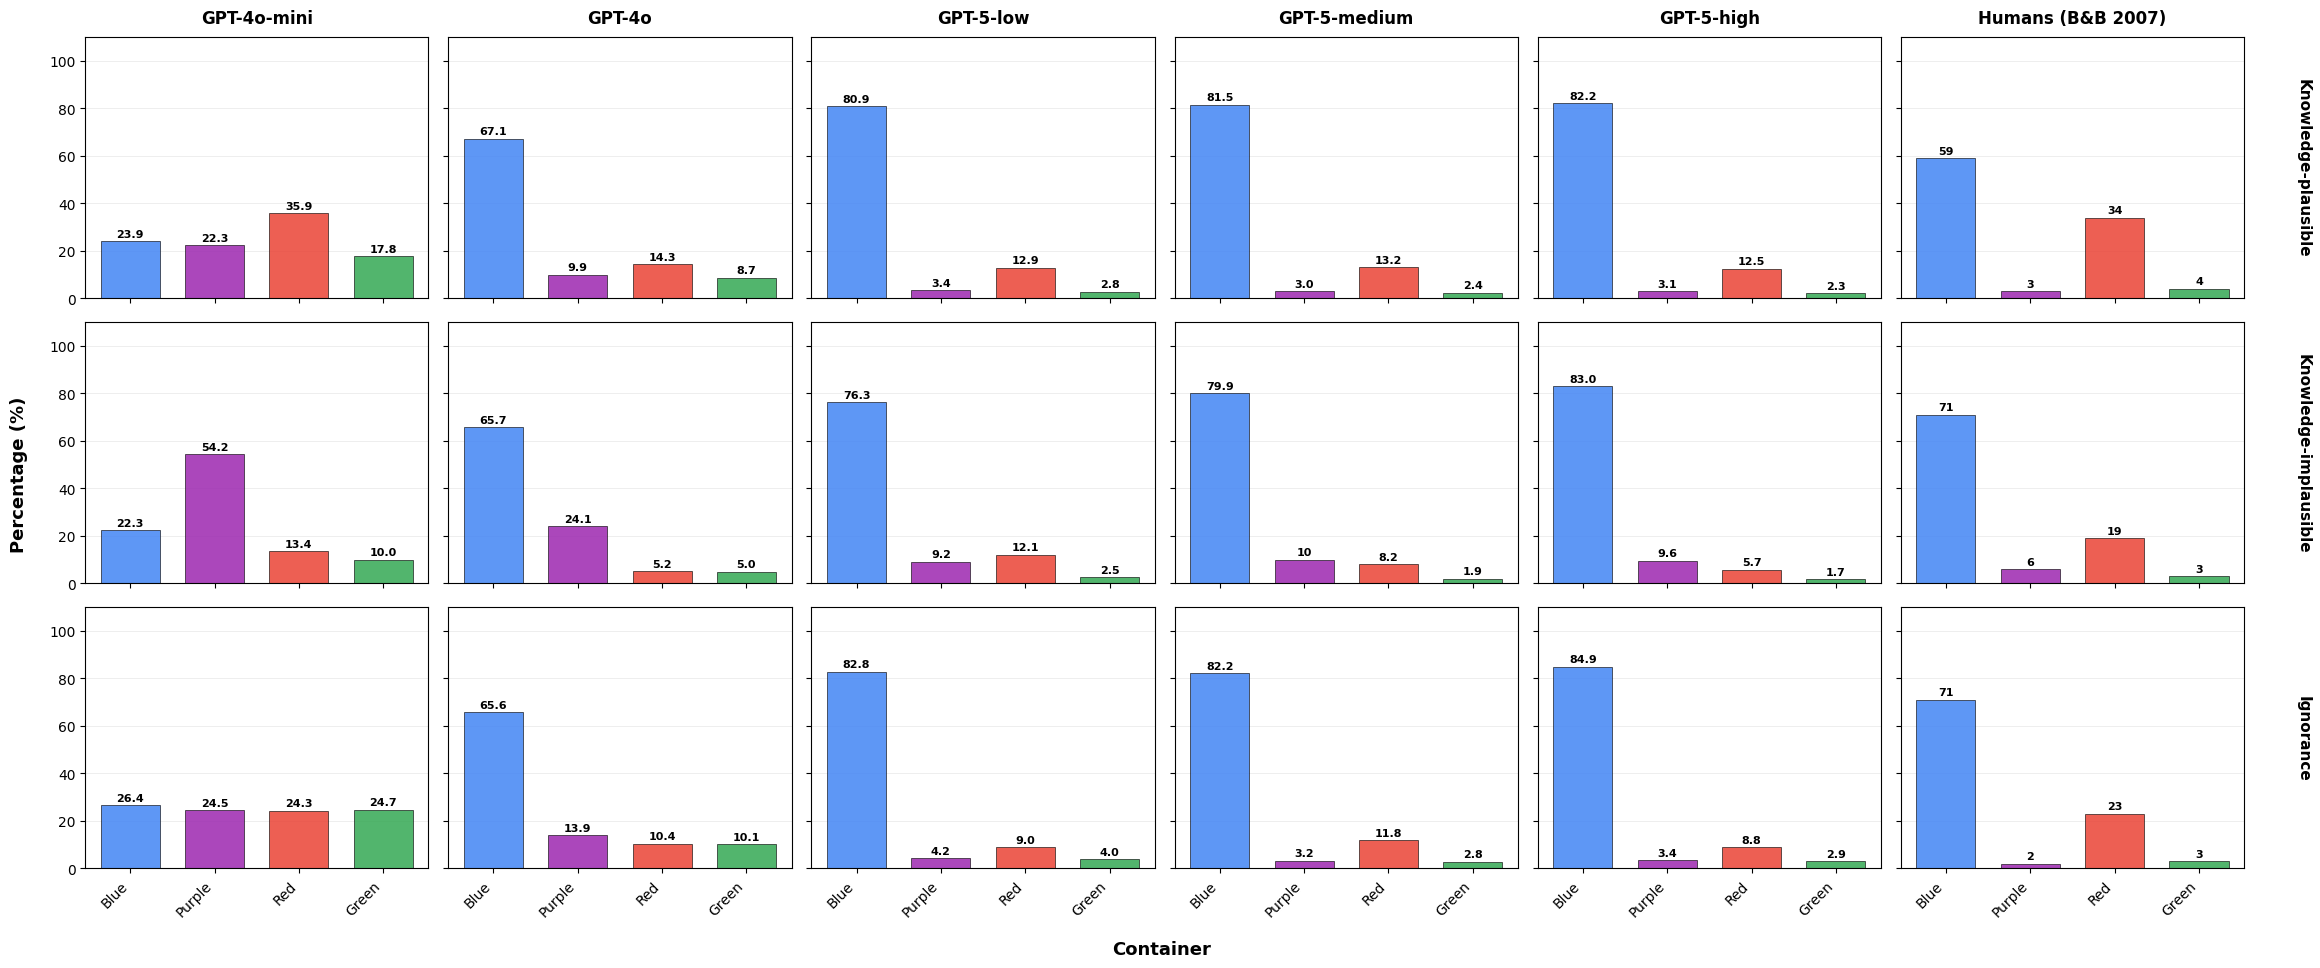

In [10]:
# Prepare data for visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Use the model_order and model_display_names defined earlier
condition_order = ['Knowledge-plausible', 'Knowledge-implausible', 'Ignorance']
container_order = ['blue', 'purple', 'red', 'green']

# Define container colors
container_colors = {
    'blue': '#4285F4',
    'purple': '#9C27B0',
    'red': '#EA4335',
    'green': '#34A853'
}

# Create figure with 3 rows (conditions) × 6 columns (models)
fig, axes = plt.subplots(3, 6, figsize=(24, 10), sharex=True, sharey=True)

# Plot data
for i, condition in enumerate(condition_order):
    for j, model in enumerate(model_order):
        ax = axes[i, j]
        
        # Get data for this model and condition
        data = combined_data[(combined_data['model'] == model) & 
                            (combined_data['condition'] == condition)]
        
        # Prepare data for plotting
        x_pos = range(len(container_order))
        heights = [data[data['container'] == c]['mean'].values[0] if len(data[data['container'] == c]) > 0 else 0 
                  for c in container_order]
        colors = [container_colors[c] for c in container_order]
        
        # Create bars
        bars = ax.bar(x_pos, heights, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5, width=0.7)
        
        # Add value labels on top of bars
        for bar, height in zip(bars, heights):
            if height > 0:  # Only show label if value > 0
                label = f'{height:.0f}' if height == int(height) else f'{height:.1f}'
                ax.text(bar.get_x() + bar.get_width()/2, height + 1, label,
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set labels and formatting
        ax.set_ylim(0, 110)  # Increased to make room for labels
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Blue', 'Purple', 'Red', 'Green'], rotation=45, ha='right', fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add column headers (model names) on top row - use display names
        if i == 0:
            display_name = model_display_names.get(model, model)
            ax.set_title(display_name, fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels (condition names) on right side
        if j == 5:
            ax.text(1.15, 0.5, condition, transform=ax.transAxes, 
                   fontsize=11, fontweight='bold', rotation=270, va='center')

# Set common labels
fig.text(0.5, 0.02, 'Container', ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Percentage (%)', va='center', rotation='vertical', 
         fontsize=13, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.03, 0.04, 0.98, 0.98])

# Save
plt.savefig('analysis_plot_predict_human.png', dpi=300, bbox_inches='tight')
print("\n✓ Saved visualization to 'analysis_plot_predict_human.png'")
plt.show()

✓ Saved visualization with std dev to 'analysis_plot_predict_human_with_std.png'


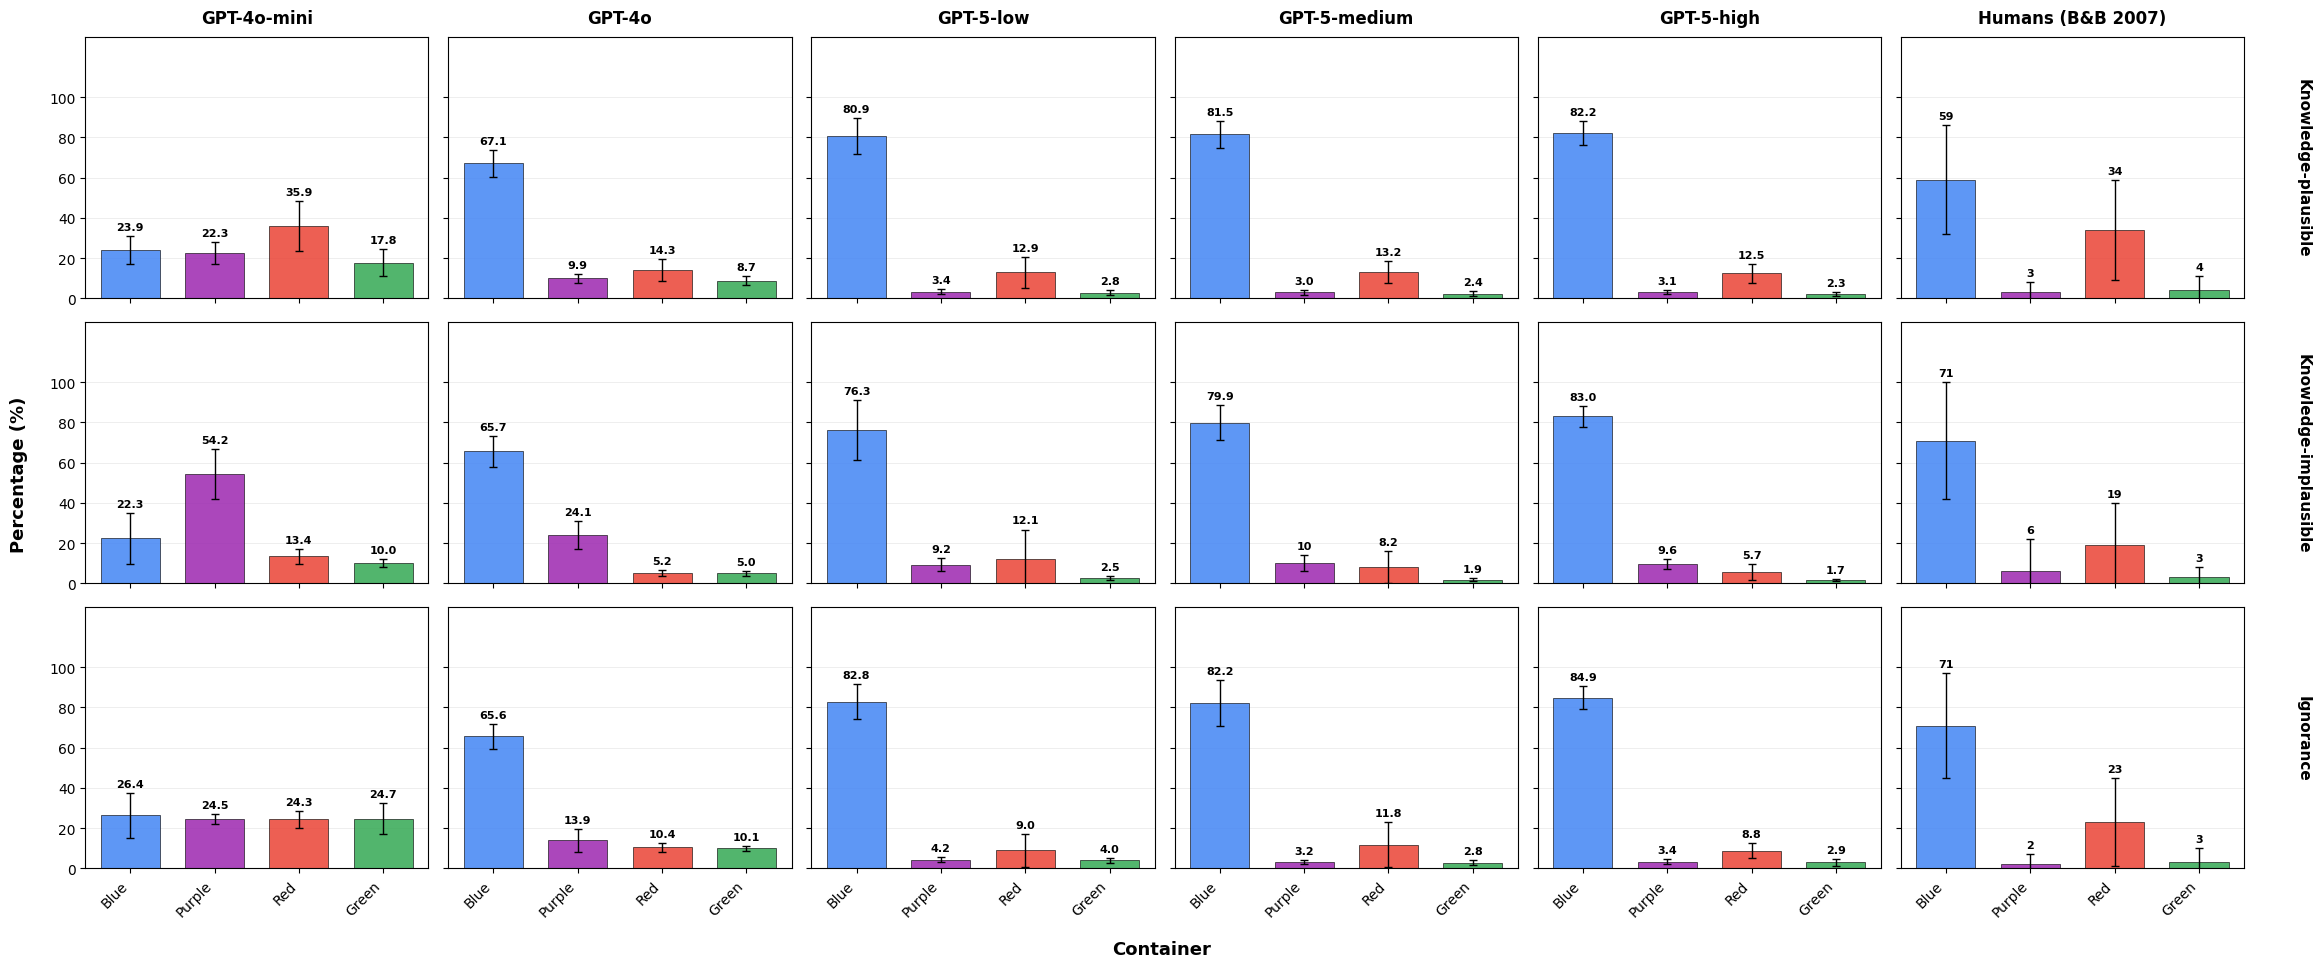

In [11]:
# Visualization with Standard Deviation Error Bars
import matplotlib.pyplot as plt

# Create figure with 3 rows (conditions) × 6 columns (models)
fig, axes = plt.subplots(3, 6, figsize=(24, 10), sharex=True, sharey=True)

# Plot data with error bars
for i, condition in enumerate(condition_order):
    for j, model in enumerate(model_order):
        ax = axes[i, j]
        
        # Get data for this model and condition
        data = combined_data[(combined_data['model'] == model) & 
                            (combined_data['condition'] == condition)]
        
        # Prepare data for plotting
        x_pos = range(len(container_order))
        heights = [data[data['container'] == c]['mean'].values[0] if len(data[data['container'] == c]) > 0 else 0 
                  for c in container_order]
        stds = [data[data['container'] == c]['std'].values[0] if len(data[data['container'] == c]) > 0 else 0 
               for c in container_order]
        # Handle NaN stds
        stds = [s if pd.notna(s) else 0 for s in stds]
        colors = [container_colors[c] for c in container_order]
        
        # Create bars with error bars
        bars = ax.bar(x_pos, heights, color=colors, alpha=0.85, edgecolor='black', linewidth=0.5, width=0.7,
                     yerr=stds, capsize=3, error_kw={'elinewidth': 1, 'capthick': 1})
        
        # Add value labels on top of bars (above error bars)
        for idx, (bar, height, std) in enumerate(zip(bars, heights, stds)):
            if height > 0:  # Only show label if value > 0
                label = f'{height:.0f}' if height == int(height) else f'{height:.1f}'
                label_y = height + std + 2 if std > 0 else height + 2
                ax.text(bar.get_x() + bar.get_width()/2, label_y, label,
                       ha='center', va='bottom', fontsize=8, fontweight='bold')
        
        # Set labels and formatting
        ax.set_ylim(0, 130)  # Increased to make room for error bars and labels
        ax.set_yticks([0, 20, 40, 60, 80, 100])
        ax.set_xticks(x_pos)
        ax.set_xticklabels(['Blue', 'Purple', 'Red', 'Green'], rotation=45, ha='right', fontsize=10)
        ax.tick_params(axis='y', labelsize=10)
        ax.grid(axis='y', alpha=0.3, linestyle='-', linewidth=0.5)
        ax.set_axisbelow(True)
        
        # Add column headers (model names) on top row
        if i == 0:
            display_name = model_display_names.get(model, model)
            ax.set_title(display_name, fontsize=12, fontweight='bold', pad=10)
        
        # Add row labels (condition names) on right side
        if j == 5:
            ax.text(1.15, 0.5, condition, transform=ax.transAxes, 
                   fontsize=11, fontweight='bold', rotation=270, va='center')

# Set common labels
fig.text(0.5, 0.02, 'Container', ha='center', fontsize=13, fontweight='bold')
fig.text(0.02, 0.5, 'Percentage (%)', va='center', rotation='vertical', 
         fontsize=13, fontweight='bold')

# Adjust layout
plt.tight_layout(rect=[0.03, 0.04, 0.98, 0.98])

# Save
plt.savefig('analysis_plot_predict_human_with_std.png', dpi=300, bbox_inches='tight')
print("✓ Saved visualization with std dev to 'analysis_plot_predict_human_with_std.png'")
plt.show()

## Key Findings

### 1. GPT-4o-mini Fails Completely - Predicts Reality Instead of Human Beliefs

GPT-4o-mini shows a fundamental misunderstanding of the task:
- **Ignorance**: Gives ~26% to each container (uniform distribution) - predicting where object COULD be, not where humans would THINK Alice looks
- **Knowledge-Plausible**: Gives 35.9% to red (where object is) vs only 23.9% to blue
- **Knowledge-Implausible**: Gives **54.2% to purple** (where object is!) vs only 22.3% to blue

**This is the same "reality-tracking" error seen in the main experiment** - GPT-4o-mini answers "where is the object?" instead of "where do humans think the character will look?"

### 2. GPT-5 Gets the Relative Bias (Delta) Right, But Absolute Values Wrong

Comparing to Ryskin 2014's meta-analysis (n=3,074):

**DELTA (change between conditions) - GPT-5 is close:**
| Source | Red Δ (K-P vs Ign) | Plausibility Δ |
|--------|-------------------|----------------|
| Ryskin 2014 (true effect) | +4.4% | +5.4% |
| GPT-5-high | +3.7% | +6.8% |

**ABSOLUTE VALUES - GPT-5 is way off:**
| Source | Red (Ignorance) | Red (K-Plausible) |
|--------|-----------------|-------------------|
| Ryskin 2014 avg | **22.6%** | **27.0%** |
| GPT-5 predictions | 8.8-11.8% | 12.5-13.2% |
| **Gap** | ~10-12 pts too low | ~14-15 pts too low |

### 3. GPT-5 Overestimates Blue AND Underestimates Red

GPT-5's core calibration problem:
- **Blue**: Predicts 80-85%, humans give 59-71% → **overestimates by ~15-20 pts**
- **Red**: Predicts 9-13%, humans give 20-27% → **underestimates by ~10-15 pts**

GPT-5 thinks humans are MORE rational (higher blue) and LESS susceptible to location-based errors (lower red) than they actually are.

### 4. GPT-4o: Closer to Human Patterns

GPT-4o predicts ~66% blue (closer to human 65-71%) and ~10-14% red (still too low, but better calibrated overall).

### 5. The Ryskin 2014 Context

Ryskin's meta-analysis found the original Birch & Bloom effects were inflated:
- Knowledge effect: d = 0.20 (vs B&B's d = 0.469) - **less than half**
- Plausibility effect: d = 0.24 (vs B&B's d = 0.645) - **less than one-third**
- Blue container: **NO significant difference** between K-Plausible and Ignorance (p = .17)

But even compared to these more modest true effects, GPT-5 still underestimates how much humans assign to non-belief containers.

### 6. Summary: GPT-5's Theory of Human Mind

GPT-5 appears to model humans as:
- More focused on belief-consistent responses (too high blue)
- Less influenced by location/reality cues (too low red)
- Showing the correct *relative* bias pattern but with wrong *absolute* calibration

**The models understand THAT humans show curse-of-knowledge bias, but not HOW MUCH.**

In [12]:
# Comparison with Ryskin 2014 meta-analysis
print("="*100)
print("COMPARISON: GPT-5 Predictions vs Ryskin 2014 Meta-Analysis")
print("="*100)

print("""
Ryskin & Brown-Schmidt (2014) replicated Birch & Bloom across 7 experiments (n=3,074)
and found the TRUE effect size is LESS THAN HALF of the original estimates:

EFFECT SIZE COMPARISON:
┌─────────────────────┬──────────────────┬──────────────────┐
│ Effect              │ Birch & Bloom    │ Ryskin 2014      │
│                     │ (2007)           │ (Meta-analysis)  │
├─────────────────────┼──────────────────┼──────────────────┤
│ Knowledge effect    │ d = 0.469        │ d = 0.20         │
│ (Red: K-P vs Ign)   │                  │ (<half original) │
├─────────────────────┼──────────────────┼──────────────────┤
│ Plausibility effect │ d = 0.645        │ d = 0.24         │
│ (Red: K-P vs K-I)   │                  │ (<1/3 original)  │
└─────────────────────┴──────────────────┴──────────────────┘

KEY FINDING FROM RYSKIN 2014:
- Blue container: NO significant difference between K-Plausible and Ignorance (p = .17)
- Red container: Significant but SMALL effect (~5-6% increase, not 11%)
""")

# Extract Ryskin's Experiment 7 data (best designed - counterbalanced)
print("\nRYSKIN 2014 EXPERIMENT 7 (n=917, counterbalanced):")
print("-"*60)
ryskin_exp7 = {
    'Ignorance': {'red': 16.53, 'n': 309},
    'Knowledge-plausible': {'red': 22.08, 'n': 300},
    'Knowledge-implausible': {'red': 16.26, 'n': 308}
}

for cond, data in ryskin_exp7.items():
    print(f"  {cond}: Red = {data['red']:.1f}% (n={data['n']})")

ryskin_red_delta = ryskin_exp7['Knowledge-plausible']['red'] - ryskin_exp7['Ignorance']['red']
ryskin_plaus_delta = ryskin_exp7['Knowledge-plausible']['red'] - ryskin_exp7['Knowledge-implausible']['red']
print(f"\n  Red Δ (K-P vs Ign): +{ryskin_red_delta:.1f}%")
print(f"  Plausibility Δ (K-P vs K-I): +{ryskin_plaus_delta:.1f}%")

# Now compare to GPT-5 predictions
print("\n" + "="*100)
print("GPT-5 PREDICTIONS vs ACTUAL HUMAN DATA")
print("="*100)

comparison_data = [
    ('Birch & Bloom 2007', 71, 59, 23, 34, 19, -12, +11, +15),
    ('Ryskin 2014 (Exp 7)', None, None, 16.5, 22.1, 16.3, None, +5.6, +5.8),
    ('GPT-5-low prediction', 82.8, 80.9, 9.0, 12.9, 12.1, -1.9, +3.9, +0.8),
    ('GPT-5-medium prediction', 82.2, 81.5, 11.8, 13.2, 8.2, -0.7, +1.4, +5.0),
    ('GPT-5-high prediction', 84.9, 82.2, 8.8, 12.5, 5.7, -2.7, +3.7, +6.8),
]

print(f"\n{'Source':<25} {'Blue(Ign)':<10} {'Blue(K-P)':<10} {'Blue Δ':<8} {'Red(Ign)':<10} {'Red(K-P)':<10} {'Red Δ':<8} {'Plaus Δ':<8}")
print("-"*100)
for row in comparison_data:
    name, b_ign, b_kp, r_ign, r_kp, r_ki, b_delta, r_delta, p_delta = row
    b_ign_str = f"{b_ign:.1f}%" if b_ign else "N/A"
    b_kp_str = f"{b_kp:.1f}%" if b_kp else "N/A"
    b_delta_str = f"{b_delta:+.1f}%" if b_delta else "N/A"
    print(f"{name:<25} {b_ign_str:<10} {b_kp_str:<10} {b_delta_str:<8} {r_ign:.1f}%{'':4} {r_kp:.1f}%{'':4} {r_delta:+.1f}%{'':2} {p_delta:+.1f}%")

print("""
INTERPRETATION:
─────────────────────────────────────────────────────────────────────────────────
1. GPT-5's Red Δ predictions (+3-4%) are CLOSER to Ryskin's true estimate (+5.6%)
   than to Birch & Bloom's inflated estimate (+11%)!

2. GPT-5 may be predicting the ACTUAL human effect more accurately than we thought,
   based on the more robust Ryskin 2014 meta-analysis.

3. However, GPT-5 still overestimates human performance on Blue container:
   - GPT-5 predicts: 80-85%
   - Birch & Bloom found: 59-71%
   - (Ryskin 2014 didn't report blue means, only significance tests)

4. The Plausibility effect predictions are mixed:
   - Ryskin 2014: +5.8%
   - GPT-5-low: +0.8% (too low)
   - GPT-5-high: +6.8% (close to Ryskin!)
""")

COMPARISON: GPT-5 Predictions vs Ryskin 2014 Meta-Analysis

Ryskin & Brown-Schmidt (2014) replicated Birch & Bloom across 7 experiments (n=3,074)
and found the TRUE effect size is LESS THAN HALF of the original estimates:

EFFECT SIZE COMPARISON:
┌─────────────────────┬──────────────────┬──────────────────┐
│ Effect              │ Birch & Bloom    │ Ryskin 2014      │
│                     │ (2007)           │ (Meta-analysis)  │
├─────────────────────┼──────────────────┼──────────────────┤
│ Knowledge effect    │ d = 0.469        │ d = 0.20         │
│ (Red: K-P vs Ign)   │                  │ (<half original) │
├─────────────────────┼──────────────────┼──────────────────┤
│ Plausibility effect │ d = 0.645        │ d = 0.24         │
│ (Red: K-P vs K-I)   │                  │ (<1/3 original)  │
└─────────────────────┴──────────────────┴──────────────────┘

KEY FINDING FROM RYSKIN 2014:
- Blue container: NO significant difference between K-Plausible and Ignorance (p = .17)
- Red containe